## Handle Real Time Data 

금융 데이터는 실시간으로 데이터가 수집되기 때문에 수집과 가공, 저장이 동시에 이뤄지는 경우가 많다. 이번 장에서는 실제 데이터를 수집하고, 확인하는 과정을 실행해 보고, 가공하여 데이터베이스에 저장하는 과정까지 실습해 보자.

In [1]:
import numpy as np
import pandas as pd

import ccxt.pro as ccxtpro
import asyncio
import datetime

### 1. Asynchronous

비동기(Asynchronous)는 작업을 동시에 실행할 수 있도록 하여, 하나의 작업이 완료될 때까지 기다리지 않고 다른 작업을 수행할 수 있는 방식이다. Python에서는 `asyncio` 및 `async/await` 키워드를 사용하여 네트워크 요청, 파일 I/O 등 대기 시간이 긴 작업을 효율적으로 처리할 수 있다. 이를 통해 프로그램이 비효율적인 대기 시간을 줄이고, 여러 작업을 병렬적으로 실행하여 성능을 향상시킬 수 있다. 즉, 요청과 결과가 동시에 일어나지 않는 것을 의미한다. 노드 사이의 작업 처리 단위를 동시에 맞추지 않음으로써 효율을 좀 더 높인다는 것이다.

**`async` (비동기 함수 정의)**

- `async` 키워드는 비동기 함수(Asynchronous Function) 를 정의할 때 사용된다.
- 비동기 함수는 일반 함수처럼 즉시 실행되지 않고, 코루틴(Coroutine) 객체를 반환한다.

**`await` (비동기 작업 실행)**

- `await` 키워드는 비동기 함수 내부에서만 사용 가능하다.
- `await`을 사용하면 비동기 작업이 완료될 때까지 기다렸다가 실행을 계속 진행한다.
- `await` 없이 실행하면 RuntimeWarning: coroutine was never awaited 오류가 발생한다.

#### 1.1 실시간 체결 강도

실습을 위해 `ccxt` library를 설치한다. ccxt는 거래소의 가상화폐 데이터를 가져올 수 있도록 도움을 주는 라이브러리이다. 한국 거래소인 upbit의 실시간 체결 강도를 가져오는 함수를 다음과 같이 작성한다.

In [2]:
async def real_time_execution_strength():
    exchange = ccxtpro.upbit()
    while True:
        ticker = await exchange.watch_ticker(symbol = "BTC/KRW")

        timestamp = ticker['timestamp']
        now = datetime.datetime.fromtimestamp(timestamp/1000)
        last = ticker['last']
        acc_ask_volume = ticker['info']['acc_ask_volume']
        acc_bid_volume = ticker['info']['acc_bid_volume']
        volume_power = acc_bid_volume / acc_ask_volume * 100

        print(f"time: {now} price: {last: ,} execution_strength: {volume_power:.2f}")

jupyter notebook 내에서는 비동기 처리가 이미 작동중이기 때문에, python 커널에서 실행하는 것이 바람직하다.

In [3]:
if __name__ == '__main__': # py 파일에서 실행
    asyncio.run(real_time_execution_strength()) 

RuntimeError: asyncio.run() cannot be called from a running event loop

혹은, `nest_asyncio`를 통해 Jupyter 내에서 실행이 가능하다. 단, 권장하지는 않는다

In [5]:
import nest_asyncio
nest_asyncio.apply()

asyncio.run(real_time_execution_strength())

time: 2025-02-15 18:54:51.661000 price:  146,909,000.0 execution_strength: 110.35
time: 2025-02-15 18:54:59.090000 price:  146,909,000.0 execution_strength: 110.35
time: 2025-02-15 18:54:59.090000 price:  146,909,000.0 execution_strength: 110.35


KeyboardInterrupt: 

#### 1.2 실시간 체결

upbit에서 가상화폐가 실시간으로 체결되는 데이터를 가져올 수 있다. 대개 1초 내에 수백 건의 거래가 체결되며, 비동기 처리를 사용해야 실시간으로 데이터를 적재할 수 있다.

In [4]:
import pprint

async def real_time_trade():
    exchange = ccxtpro.upbit()
    while True:
        trade = await exchange.watch_trades(symbol="BTC/KRW")
        pprint.pprint(trade)

In [9]:
asyncio.run(real_time_trade())

[{'amount': 0.00521753,
  'cost': 766522.98489,
  'datetime': '2025-02-15T10:01:38.008Z',
  'fee': {'cost': None, 'currency': None},
  'fees': [],
  'id': '17396136979760000',
  'info': {'ask_bid': 'BID',
           'best_ask_price': 146913000,
           'best_ask_size': 0.03239076,
           'best_bid_price': 146912000,
           'best_bid_size': 0.48796783,
           'change': 'RISE',
           'change_price': 362000.0,
           'code': 'KRW-BTC',
           'prev_closing_price': 146551000.0,
           'sequential_id': 17396136979760000,
           'stream_type': 'SNAPSHOT',
           'timestamp': 1739613698008,
           'trade_date': '2025-02-15',
           'trade_price': 146913000.0,
           'trade_time': '10:01:37',
           'trade_timestamp': 1739613697976,
           'trade_volume': 0.00521753,
           'type': 'trade'},
  'order': None,
  'price': 146913000.0,
  'side': 'buy',
  'symbol': 'BTC/KRW',
  'takerOrMaker': None,
  'timestamp': 1739613698008,
  'typ

KeyboardInterrupt: 

#### 1.3 실시간 호가

거래가 실제로 이뤄진 경우 체결로 기록되지만, 매수자와 매도자가 거래 전 제시하는 금액을 각각 매수호가와 매도 호가라고 한다. 이를 합쳐 **호가**라고 하며, 이 금액의 차이를 **Bid-Ask Spread**라고 한다.

In [11]:
async def real_time_bid_ask():
    exchange = ccxtpro.upbit()
    while True:
        orderbook = await exchange.watch_order_book(symbol="BTC/KRW")
        pprint.pprint(orderbook)
        await exchange.close()

In [13]:
asyncio.run(real_time_bid_ask())

{'asks': [[146917000.0, 0.03926307], [146918000.0, 3.61578804], [146920000.0, 0.59928279], [146924000.0, 0.00709662], [146925000.0, 0.00053425], [146929000.0, 0.01189731], [146930000.0, 0.50325613], [146931000.0, 0.05569305], [146961000.0, 0.00010208], [146967000.0, 0.00040884], [146978000.0, 0.0070844], [146985000.0, 0.00343171], [146987000.0, 6.804e-05], [146991000.0, 0.13680676], [146992000.0, 0.00487801]],
 'bids': [[146915000.0, 0.01593154], [146914000.0, 0.04025453], [146913000.0, 0.05778384], [146912000.0, 0.40752654], [146911000.0, 0.00293023], [146910000.0, 0.00171683], [146909000.0, 0.02531745], [146900000.0, 0.03176151], [146896000.0, 0.00018], [146887000.0, 0.00272318], [146883000.0, 0.00204142], [146871000.0, 0.00531777], [146861000.0, 0.00068], [146852000.0, 7.231e-05], [146850000.0, 0.00120036]],
 'datetime': '2025-02-15T10:04:30.892Z',
 'nonce': None,
 'symbol': 'BTC/KRW',
 'timestamp': 1739613870892}
{'asks': [[146917000.0, 0.03926307], [146918000.0, 3.61578804], [1469

KeyboardInterrupt: 

#### 1.4 다중 자산의 가격 데이터 수집

실제 데이터 수집을 위해서는 단일 자산이 아닌 다중 자산의 데이터를 실시간으로 수집해야 하는 경우가 많다. 이 경우 loop를 통해 여러 자산을 비동기로 효율적으로 불러올 수 있다.

In [14]:
async def loop(exchange, symbol):
    while True:
        trade = await exchange.watch_trades(symbol)
        pprint.pprint(trade)

async def real_time_multi_asset():
    exchange = ccxtpro.upbit()
    symbols = ['BTC/KRW', 'ETH/KRW', 'XRP/KRW']

    coros = [loop(exchange, symbol) for symbol in symbols]
    await asyncio.gather(*coros)
    await exchange.close()

asyncio.run(real_time_multi_asset())

[{'amount': 0.001605,
  'cost': 235795.365,
  'datetime': '2025-02-15T10:07:33.639Z',
  'fee': {'cost': None, 'currency': None},
  'fees': [],
  'id': '17396140536120000',
  'info': {'ask_bid': 'ASK',
           'best_ask_price': 146920000,
           'best_ask_size': 0.46371795,
           'best_bid_price': 146913000,
           'best_bid_size': 0.01690955,
           'change': 'RISE',
           'change_price': 362000.0,
           'code': 'KRW-BTC',
           'prev_closing_price': 146551000.0,
           'sequential_id': 17396140536120000,
           'stream_type': 'SNAPSHOT',
           'timestamp': 1739614053639,
           'trade_date': '2025-02-15',
           'trade_price': 146913000.0,
           'trade_time': '10:07:33',
           'trade_timestamp': 1739614053612,
           'trade_volume': 0.001605,
           'type': 'trade'},
  'order': None,
  'price': 146913000.0,
  'side': 'sell',
  'symbol': 'BTC/KRW',
  'takerOrMaker': None,
  'timestamp': 1739614053639,
  'type': N

KeyboardInterrupt: 

### 2. Handling Multi Web Socket Data

웹소켓(WebSocket)은 클라이언트와 서버 간에 지속적인 양방향 통신을 가능하게 하는 프로토콜이다. 일반적인 HTTP 요청과 달리, 웹소켓은 한 번 연결되면 지속적으로 데이터를 주고받을 수 있어 실시간성이 중요한 서비스(예: 주식 시세, 채팅, 게임 등)에 적합하다.

ccxt의 모듈은 하나의 웹 소켓으로 이뤄져 있으며, 다중 웹소켓을 호출해 실시간으로 처리할 수 있다.

In [15]:
async def watch_ticker(exchange, symbol):
    """
    ticker를 실시간으로 관측하는 함수
    :param exchange: 거래소를 지정한다.
    :param symbol: 관찰할 가상화폐의 심볼을 지정한다.
    """
    while True:
        ticker = await exchange.watch_ticker(symbol)
        pprint.pprint(ticker)

async def watch_order_book(exchange, symbol):
    while True:
        order_book = await exchange.watch_order_book(symbol)
        pprint.pprint(order_book)

async def web_socket():
    symbol = "BTC/KRW"
    exchange = ccxtpro.upbit()

    coros = [ # 다중 웹소켓 처리
        watch_ticker(exchange, symbol),
        watch_order_book(exchange, symbol),
    ]

    await asyncio.gather(*coros)
    await exchange.close()

asyncio.run(web_socket())

{'ask': None,
 'askVolume': None,
 'average': 146731500.0,
 'baseVolume': 1354.5190273,
 'bid': None,
 'bidVolume': None,
 'change': 361000.0,
 'close': 146912000.0,
 'datetime': '2025-02-15T10:08:37.655Z',
 'high': 147598000.0,
 'indexPrice': None,
 'info': {'acc_ask_volume': 206.25263714,
          'acc_bid_volume': 227.71368169,
          'acc_trade_price': 63778431323.84846,
          'acc_trade_price_24h': 198488954881.77502,
          'acc_trade_volume': 433.96631883,
          'acc_trade_volume_24h': 1354.5190273,
          'ask_bid': 'BID',
          'change': 'RISE',
          'change_price': 361000.0,
          'change_rate': 0.0024633063,
          'code': 'KRW-BTC',
          'delisting_date': None,
          'high_price': 147598000.0,
          'highest_52_week_date': '2025-01-20',
          'highest_52_week_price': 163325000.0,
          'is_trading_suspended': False,
          'low_price': 146200000.0,
          'lowest_52_week_date': '2024-02-26',
          'lowest_52_w

KeyboardInterrupt: 

### 3. Collect and Store Real time Data

데이터베이스 시스템과 결합하여 Upbit로부터 실시간으로 가격 데이터를 수집한 뒤, SQL DB에 저장하는 것을 구현할 수 있다. 

#### 3.1 Create Table

`sqlite3` library를 이용해 기존의 price.db를 연결한다.

In [12]:
import sqlite3

DB_NAME = "price.db"

conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

BTC price를 저장할 table을 생성한다. primary key는 date로 하고, value를 저장할 컬럼의 이름은 price로 한다. type은 각각 text와 real이다.

In [13]:
cursor.execute("""
    create table if not exists btc_price (
        date text primary key,
        price real not null
    )
""")
conn.commit()
conn.close()

#### 3.2 Collect data

`ccxt` library 내에서 비동기 처리를 지원하는 모듈을 import 하여 거래소에 연결한다.

In [14]:
import ccxt.async_support as ccxt
exchange = ccxt.upbit()

비동기 처리 함수 `fetch_and_store_btc_price()`를 지정한다. 내부에서는 거래소로부터 데이터를 받아온 뒤 SQL에 실시간 적재하도록 작성한다.

In [29]:
async def fetch_and_store_btc_price():
    while True:
        try:
            ticker = await exchange.fetch_ticker("BTC/KRW") # BTC 가격 가져오기
            price = ticker['last']
            timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # SQLite3에 저장
            conn = sqlite3.connect(DB_NAME) # connect
            cursor = conn.cursor()
            cursor.execute("INSERT OR REPLACE INTO BTC_price (date, price) VALUES (?, ?)", (timestamp, price))
            conn.commit()
            conn.close()

            print(f"[{timestamp}] BTC Price: {price} KRW")
        
        except Exception as e:
            print(f"error : {e}")

        await asyncio.sleep(1) # 1초 간격으로 요청 (실시간 감시)

In [30]:
asyncio.run(fetch_and_store_btc_price())

[2025-02-15 19:21:23] BTC Price: 146900000.0 KRW
[2025-02-15 19:21:25] BTC Price: 146900000.0 KRW
[2025-02-15 19:21:27] BTC Price: 146900000.0 KRW
[2025-02-15 19:21:29] BTC Price: 146900000.0 KRW
[2025-02-15 19:21:32] BTC Price: 146900000.0 KRW
[2025-02-15 19:21:34] BTC Price: 146900000.0 KRW
[2025-02-15 19:21:36] BTC Price: 146900000.0 KRW
[2025-02-15 19:21:38] BTC Price: 146900000.0 KRW
[2025-02-15 19:21:40] BTC Price: 146900000.0 KRW


KeyboardInterrupt: 

#### 3.3 저장된 데이터 확인

database에 저장된 가격 데이터를 확인한다. date는 string 형태로 저장되기 때문에 적절한 변환이 필요하다.

In [15]:
conn = sqlite3.connect(DB_NAME)
data = pd.read_sql_query("SELECT * FROM btc_price", conn)

<Axes: >

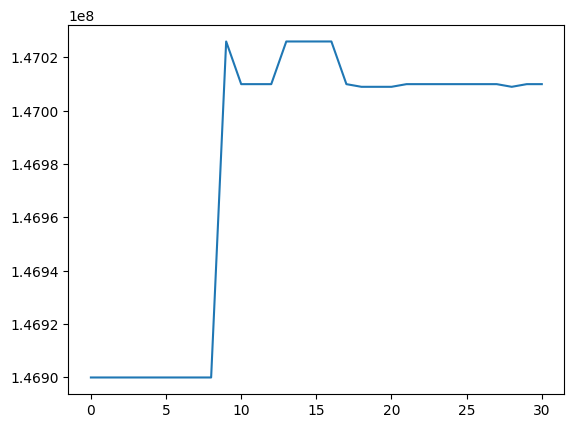

In [18]:
data['price'].plot()

In [19]:
conn.close()